# 高速化
* cython
* numba
* 再帰関数の部分をメモ化するか動的計画法を使う

In [1]:
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra #フィボナッチヒープを使用している
import math
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import time
from InfMaxProblem import ICmodel
import sys
sys.setrecursionlimit(20000)

%matplotlib inline

### ランダムグラフ作成関数

In [2]:
def make_random_graph(V_size, E_size):
    E = np.zeros(V_size**2)
    p = np.zeros(V_size**2)
    
    index_list = [i for i in range(V_size**2) if i%(V_size+1) != 0]
    
    for i in random.sample(index_list, k=E_size):
        E[i] = 1
        p[i] = random.randint(1,100)/100
    E = E.reshape(V_size, V_size)
    p = p.reshape(V_size, V_size)
    
    return [E, p]

In [3]:
g = make_random_graph(500, 1000)
E = g[0]
p = g[1]

In [4]:
E

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
G = nx.DiGraph(E)

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


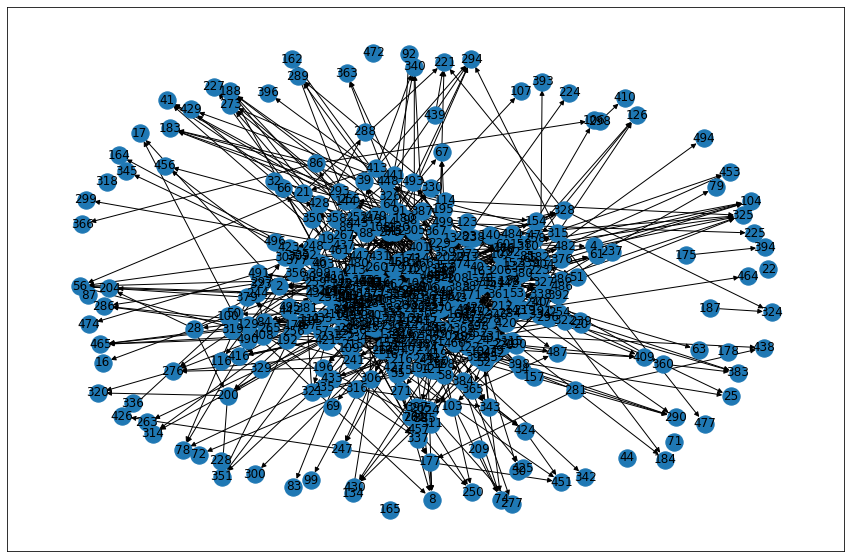

In [6]:
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(G)

In [7]:
# 隣接行列を隣接リストに変換する
def edge_list_change(E):
    E_list = []
    for i, E_i in enumerate(E):
        for j, E_i_j in enumerate(E_i):
            if E_i_j > 0:
                E_list.append([i,j])
    return E_list

In [8]:
# 隣接行列を隣接リストに変換する(確率付き)
def edge_p_list_change(E,p):
    E_list = []
    for i, E_i in enumerate(E):
        for j, E_i_j in enumerate(E_i):
            if E_i_j > 0:
                E_list.append([i,j,p[i][j]])
    return E_list

In [9]:
# edge_p_list_change(E,p)

In [10]:
def get_pass(start, end, pass_info):
    shortest_pass = []
    t = end
    while t != -9999:
        shortest_pass.append(t)
        t = pass_info[t]
        if t == start:
            shortest_pass.append(start)
            shortest_pass.reverse()
            return shortest_pass
    return []

In [11]:
# 任意の頂点からvへの最短経路とvへの到達確率を求める関数
def MIIOA(p, theta):
    V_size = len(p)
    
    # limitでtheta以下になるようなパスを探索しなくなる
    result = dijkstra(csr_matrix(-np.log(p)), return_predecessors=True, limit=-np.log(theta))
    
    # 任意のuから任意のvまでの最短距離を最大確率に変換
    shortest_distance = np.exp(1)**(-result[0])
    
    # 任意のuから任意のvまでの最短経路を保存
    MIIA = [[get_pass(u,v,result[1][u]) for u in range(V_size) if get_pass(u, v, result[1][u]) != []] 
            for v in range(V_size)]
    MIOA = [[get_pass(u,v,result[1][u]) for v in range(V_size) if get_pass(u, v, result[1][u]) != []] 
            for u in range(V_size)]
    return [MIIA, MIOA, shortest_distance]

# vまでのMIPの確率がtheta以上のパスを列挙する関数
def MIIA(v, info):
    return info[0][v]

# vから各頂点のMIPの確率がtheta以上のパスを列挙する関数
def MIOA(v, info):
    return info[1][v]


def pp(u, v, info):
    return info[2][u][v]

# info = MIIOA(p, 0.01)
# print(MIIA(5,info))
# print(MIOA(5,info))
# print(pp(0,5,info))
# [[0, 9, 3, 5], [1, 2, 6, 9, 3, 5], [2, 6, 9, 3, 5], [3, 5], [6, 9, 3, 5], [7, 2, 6, 9, 3, 5], [9, 3, 5]]
# [[5, 3], [5, 6], [5, 6, 9]]
# 0.169344

In [12]:
# MIIA(v, theta)で得られた木において、uのincoming頂点集合(uに入ってくる頂点集合)
def N_in(u, MIIA_trees):
    N_in_nodes = []
    for tree in MIIA_trees:
        if u in tree:
            N_in_index = tree.index(u) - 1
            if N_in_index >= 0:
                N_in_nodes.append(tree[N_in_index])
    return list(set(N_in_nodes))

#info = MIIOA(p, 0.01)
# N_in(9, MIIA(5, info))
# [0, 6]

In [13]:
# MIIA(v, theta)で得られた木において、uのoutcoming頂点(uから出ていく頂点集合)
def N_out(u, MIIA_trees):
    for tree in MIIA_trees:
        if u in tree:
            N_out_index = tree.index(u) + 1
            if N_out_index < len(tree):
                return tree[N_out_index]
    return None

# N_out(9, MIIA(5, info))
# 3

In [14]:
def ap(u, S, MIIA_trees, info):
    if u in S:
        return 1
    elif len(N_in(u, MIIA_trees)) == 0:
        return 0
    else:
        N_in_u = N_in(u, MIIA_trees)
        prod = 1
        for w in N_in_u:
            prod *= (1 - ap(w, S, MIIA_trees, info)*pp(w, u, info))
        return 1 - prod

# ap(5, [7,9], MIIA(2, info), info)
# 0.3358000000000001

In [15]:
def sigma_M(S, info):
    V_size = len(info[2])
    result = 0
    for v in range(V_size):
        result += ap(v, S, MIIA(v, info), info)
    return result

# sigma_M([1], info, p)
# 2.2380243040000005

In [16]:
# 考え得るuはMIIA_treesに含まれているノード
def compute_alpha(v, u, MIIA_trees, S, info):
    if u == v:
        return 1
    else:
        w = N_out(u, MIIA_trees)
        if w in S:
            return 0
        else:
            N_in_w_not_u = list(set(N_in(w, MIIA_trees)) - set([u]))
            prod = 1
            for u_ in N_in_w_not_u:
                prod *= (1 - ap(u_, S, MIIA_trees, info)*pp(u_, w, info))
            return compute_alpha(v, w, MIIA_trees, S, info) * pp(u, w, info) * prod

# compute_alpha(0,7,MIIA(0,info),[3],info)
# 0.43

In [17]:
# 遅いから使ってない
# 二次元リストを一次元リストに変換し、重複削除する関数
def ll_to_l(ll):
    l = []
    for i in ll:
        l += i
    l = list(set(l))
    return l

In [22]:
def MIA(p, k, theta):
    # initialization
    S = []
    V_size = len(p)
    IncInf = [0 for v in range(V_size)]
    
    start = time.time()
    info = MIIOA(p, theta)
    end = time.time()
    print(end-start)
    
    MIIA_sets = info[0]
    MIOA_sets = info[1]
    
    # ノードの集合
    start = time.time()
    MIIA_node_sets = [list(set(itertools.chain.from_iterable(MIIA(v, info)))) for v in range(V_size)]
    MIOA_node_sets = [list(set(itertools.chain.from_iterable(MIIA(v, info)))) for v in range(V_size)]
    end = time.time()
    print(end-start)
    
    for v in range(V_size):
        # ノードの集合
        MIIA_node = MIIA_node_sets[v]
        MIOA_node = MIOA_node_sets[v]
        
        MIIA_set = MIIA_sets[v]
        #6 不明
        #7 不明
        for u in MIIA_node:
            IncInf[u] += compute_alpha(v, u, MIIA_set, S, info)
    print("complete init",time.time())

    # main loop
    for i in range(k):
        print(i)
        # 14
        max_value = 0
        u = None
        for v in range(V_size):
            if v not in S:
                if max_value < IncInf[v]:
                    max_value = IncInf[v]
                    u = v
        # 15
        MIOA_sub_S = list(set(MIOA_node_sets[u]) - set(S))
        for v in MIOA_sub_S:
            # 17
            MIIA_sub_S = list(set(MIIA_node_sets[v]) - set(S))
            for w in MIIA_sub_S:
                IncInf[w] -= compute_alpha(v, w, MIIA_sets[v], S, info) * (1 - ap(w, S, MIIA_sets[v], info))
        # 22
        S.append(u)
        print("#",time.time())
        #23
        MIOA_sub_S = list(set(MIOA_node_sets[u]) - set(S))
        for v in MIOA_sub_S:
            #24 不明
            #25 不明
            # 26
            MIIA_sub_S = list(set(MIIA_node_sets[v]) - set(S))
            for w in MIIA_sub_S:
                IncInf[w] += compute_alpha(v, w, MIIA_sets[v], S, info) * (1 - ap(w, S, MIIA_sets[v], info))
        
    return S

# MIA(p, 2, 0.01)
# [7, 9]
# %time MIA(p, 2, 0.01)
# node = 50 edge=140
# Wall time: 6min 18s
# [15, 34]

In [19]:
def list_rec(i,l):
    if i < len(l):
        l[i] = i+2
        return list_rec(i+1,l)
    else:
        return l

l = [0 for i in range(3)]
list_rec(0,l)

[2, 3, 4]

In [20]:
# %time MIIOA(p, 0.1)

In [23]:
%time MIA(p, 2, 0.2)

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


3.7548580169677734
0.023053884506225586
complete init 1575622828.406765
0
# 1575622831.0243042
1
# 1575622832.466172
CPU times: user 29.5 s, sys: 265 ms, total: 29.8 s
Wall time: 32.2 s


[468, 458]

In [24]:
%time MIA(p, 2, 0.1)

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


4.39723801612854
0.04006505012512207
complete init 1575623059.5033028
0
# 1575623100.097697
1
# 1575623130.3121111
CPU times: user 4min 40s, sys: 1.34 s, total: 4min 41s
Wall time: 4min 57s


[468, 458]

モンテカルロとの違いについて、ダイクストラを計算するのが１回で済むため、こちらの方のアルゴリズムの方が大きい規模のネットワークでも扱いやすい。向こうは、live_edgeモデルでいちいちグラフ構造が変わるため、何回もダイクストラで計算しなくてはならない。

In [47]:
reach_set = set([])
reach_set |= set(nx.dfs_preorder_nodes(G,source=0))
reach_set |= set(nx.dfs_preorder_nodes(G,source=1))
#set(nx.dfs_preorder_nodes(G,source=0)) | set(nx.dfs_preorder_nodes(G,source=1))
len(reach_set)

402

In [37]:
set([3,4,5]) | set([3,5,6])

{3, 4, 5, 6}